## Modes in bent and angled waveguides

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/Modes_bent_angled.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/Modes_bent_angled.ipynb), or just follow along with the output below.

Here, we illustrate how we can use the `ModeSource` and `ModeMonitor` objects to study modes in bent waveguides and in waveguides that are not propagating along one of the simulation axes. 

In [1]:
# # get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# make sure notebook plots inline
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
from tidy3d import web

### Bent waveguide setup

First, we will study mode injection and decomposition in a microring. We start by defining various simulation parameters, and the structures that enter the simulation. We simulate a silicon ring on a silicon oxide substrate, and the ring is defined using two Cylinders.

In [2]:
# Unit length is micron.
wg_height = 0.22
wg_width = 0.9
# Radius of the simulated ring
radius = 2 

# Waveguide and substrate materials
mat_wg = td.Medium(epsilon=3.48**2)
mat_sub = td.Medium(epsilon=1.45**2)

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction
sim_length = radius + 1.5

# Simulation domain size, resolution and total run time
sim_size = [sim_length, 2*(radius + 1.5), 3]
resolution = 40
run_time = 20/fwidth

# Substrate
substrate = td.Box(
    center=[0, 0, -sim_size[2]],
    size=[td.inf, td.inf, 2*sim_size[2]-wg_height],
    material=mat_sub)

# The ring is made by two cylinders
cyl1 = td.Cylinder(
    center=[0, 0, 0],
    axis='z',
    radius=radius - wg_width/2,
    height=wg_height,
    material=td.Medium(epsilon=1.0)
)
cyl2 = td.Cylinder(
    center=[0, 0, 0],
    axis='z',
    radius=radius + wg_width/2,
    height=wg_height,
    material=mat_wg
)

### Modal planes in bent waveguides

As usual, when initializing `ModeSource` and `ModeMonitor` objects, one of the three values of the `size` parameter must be zero. In this example, we also need to define the axis of the bend and the radius of the curvature. The definitions are schematically illustrated in the image below. The bend axis is the axis normal to the plane in which the bend lies, and can be one of `'x', 'y', 'z'` (`'z'` in the diagram below). The bend radius is counted from the center of the mode plane to the center of the curvature, along the axis that is orthogonal to both the bend axis and the propagation direction. This radius can also be negative, if the center of the mode plane is smaller than the center of the bend, which is what we will encounter in this example. Finally, we note that the `'forward'` and `'backward'` direction parameter can still be used to distinguish between the two propagation directions as in regular modal sources and monitors.

<img src="img/ring_modes.png" width=800>

In [3]:
# Modal source
msource = td.ModeSource(
    center=[0, -radius, 0],
    size=[0, 3, 2],
    source_time = td.GaussianPulse(
        frequency=freq0,
        fwidth=fwidth),
    direction='forward')

# xy-plane frequency-domain field monitor; slightly offset in z for better structure viz below
freq_mnt = td.FreqMonitor(
    center=[0, 0, 0.05],
    size=[100, 100, 0],
    freqs=[freq0])

# Mode monitor after one-half round-trip around the ring
mnt_f = td.ModeMonitor(
    center=[0, radius, 0],
    size=[0, 3, 2],
    freqs=[freq0],
    store=["flux", "mode_amps"])

### Running the simulation 

First, we visualize the simulation to make sure we have set up the device correctly. We will use `'absorber'` boundaries along the x-direction, because these boundaries work better than PML for structures which are not translationally invariant along the boundary normal direction.

Initializing simulation...
Mesh step (micron): [2.50e-02, 2.50e-02, 2.50e-02].
Simulation domain in number of grid points: [220, 304, 144].
Total number of computational grid points: 9.63e+06.
Total number of time steps: 23864.
Estimated data size (GB) of monitor monitor: 0.0032.
Estimated data size (GB) of monitor monitor_1: 0.0000.


<AxesSubplot:title={'center':'yz-plane at x=0.00e+00um'}, xlabel='y (um)', ylabel='z (um)'>

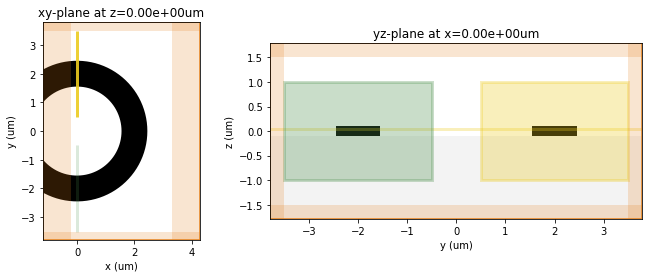

In [4]:
# Simulation
sim = td.Simulation(
    center=[sim_length/2 - 0.2, 0, 0],
    size=sim_size,
    resolution=resolution, 
    structures=[substrate, cyl2, cyl1], 
    sources=[msource], 
    monitors=[freq_mnt, mnt_f],
    run_time=run_time,
    pml_layers=['absorber', 'standard', 'standard'],
    subpixel=True)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.viz_eps_2D(normal='z', ax=ax1, monitor_alpha=0.9, source_alpha=0.2);
sim.viz_eps_2D(normal='x', ax=ax2);

Next, we can compute the source modes to make sure that we inject the desired mode. When a bend radius $R$ is used, the effective index $n$ returned by the solver is such that the field evolves as $e^{i n k_0 R \phi}$, with $\phi$ the polar angle and $k_0 = \omega/c$. This definition is such that in the limit of infinite $R$, the effective index approaches that of a straight waveguide with the same cross-section. Based on our discussion and diagram above, we set the `bend_axis` to `'z'`, and the `bend_radius` at the position of the source is negative.

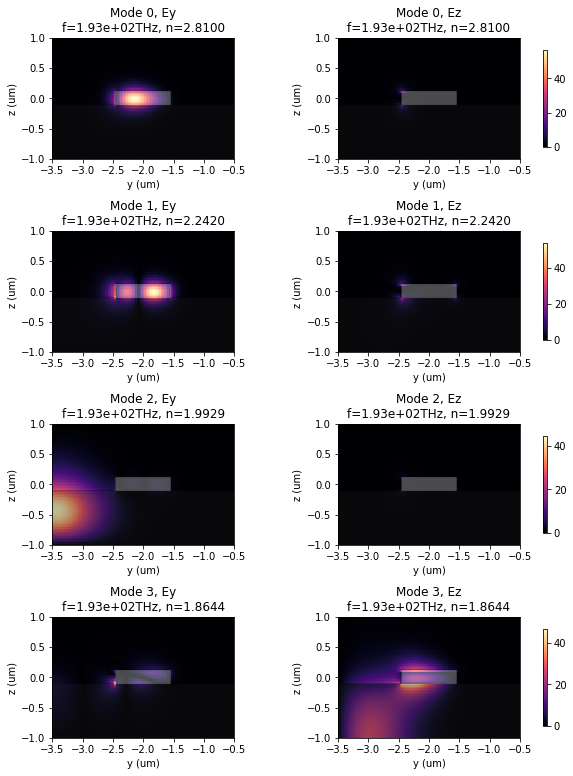

In [5]:
sim.compute_modes(msource, Nmodes=4, bend_radius=-radius, bend_axis='z')
sim.viz_modes(msource, cbar=True)
plt.show()

Note that the last two of the computed modes are unphysical. The fundamental mode looks like what we would expect, and we will use that mode for injection. Note also that in the mode monitor, which is situated radially from the mode source, we need to use a positive value for the bend radius. We need to make all these settings known to the simulation object, after which we can run the simulation.

In [6]:
sim.set_mode(msource, mode_ind=0, bend_radius=-radius, bend_axis='z') # note: negative radius
sim.set_monitor_modes(mnt_f, bend_radius=radius, bend_axis='z', Nmodes=2) # note: positive radius

task_id = web.run(sim, task_name="ring_mode")

Mode set, recommend verifying using viz_modes.
Uploading the json file...
Project 'ring_mode-16b87a75a90f97c8' status: success...                                

Loading monitor data into simulation.
Applying source normalization to all frequency monitors using source index 0.


Finally, we visualize the results and verify that we get very close to unity transmission through the half-circle.

Transmission flux:  0.998298222815035
Flux in mode 0:     0.9997522898557306


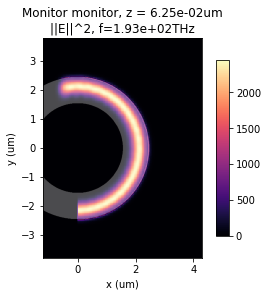

In [7]:
mdata = sim.data(mnt_f)
print("Transmission flux: ", np.abs(mdata["flux"][0, 0]))
print("Flux in mode 0:    ", np.abs(mdata["mode_amps"][1][0, 0])**2) # note: 'backward' mode amplitude

im = sim.viz_field_2D(freq_mnt, cbar=True, val='int');

### Angled waveguide setup

`Mode` objects can also be set to inject and record propagation at a given angle with respect to the axis normal to the mode plane. The `angle_theta` and `angle_phi` parameters of `ModeSource` and `ModeMonitor` objects define the injection axis as illustrated in the figure below, with respect to the axis normal to the mode plane (`x` in the figure). Note that `angle_theta` must be smaller than $\pi/2$. To inject in the backward direction, we can still use the `direction` parameter as also shown in the figure. Similarly, the mode amplitudes computed in mode monitors are defined w.r.t. the `forward` and `backward` directions as illustrated.

<img src="img/mode_angled.png" width=500>

In [8]:
# Simulation size
sim_length = 3
sim_size = [sim_length, 5, 2]

# Define an angled waveguide as a PolySlab
wg_width = 0.45
theta = np.pi/4
phi = np.pi

verts_x = np.array([-10, 10, 10, -10])
verts_y = verts_x * np.tan(theta)
verts_y[:2] -= wg_width / 2 / np.cos(theta)
verts_y[2:] += wg_width / 2 / np.cos(theta)
verts_y *= np.cos(phi) # this only works for phi = 0 or pi
waveguide = td.PolySlab(
    vertices=np.stack((verts_x, verts_y), axis=1),
    z_cent=0,
    z_size=wg_height,
    material=mat_wg)

# Modal source
src_pos = 0
msource = td.ModeSource(
    center=[src_pos, 0, 0],
    size=[0, 3, 2],
    source_time = td.GaussianPulse(
        frequency=freq0,
        fwidth=fwidth),
    direction='forward',
    angle_theta=theta,
    angle_phi=phi)

# Angled modal monitor
mnt_f = td.ModeMonitor(
    center=[sim_length/2-0.5, (sim_length/2-0.5)*np.tan(theta)*np.cos(phi), 0],
    size=[0, 3, 2],
    freqs=[freq0],
    store=["mode_amps", "flux"],
    angle_theta=theta,
    angle_phi=phi)

We will once again use `'absorber'` boundaries along x, since the angled waveguide is not translationally invariant in that direction.

Initializing simulation...
Mesh step (micron): [2.50e-02, 2.50e-02, 2.50e-02].
Simulation domain in number of grid points: [200, 224, 104].
Total number of computational grid points: 4.66e+06.
Total number of time steps: 23864.
Estimated data size (GB) of monitor monitor: 0.0022.
Estimated data size (GB) of monitor monitor_1: 0.0000.


<AxesSubplot:title={'center':'yz-plane at x=0.00e+00um'}, xlabel='y (um)', ylabel='z (um)'>

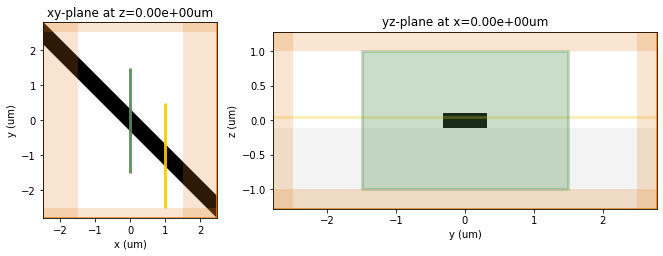

In [9]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    resolution=resolution, 
    structures=[waveguide, substrate], 
    sources=[msource], 
    monitors=[freq_mnt, mnt_f],
    run_time=run_time,
    pml_layers=['absorber', 'standard', 'standard'])

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 2.2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.viz_eps_2D(normal='z', ax=ax1, monitor_alpha=0.9, source_alpha=0.9);
sim.viz_eps_2D(normal='x', ax=ax2);

### Running the simulation

As before, we will examine the modes of the waveguide, select the mode to inject, and run the simulation.

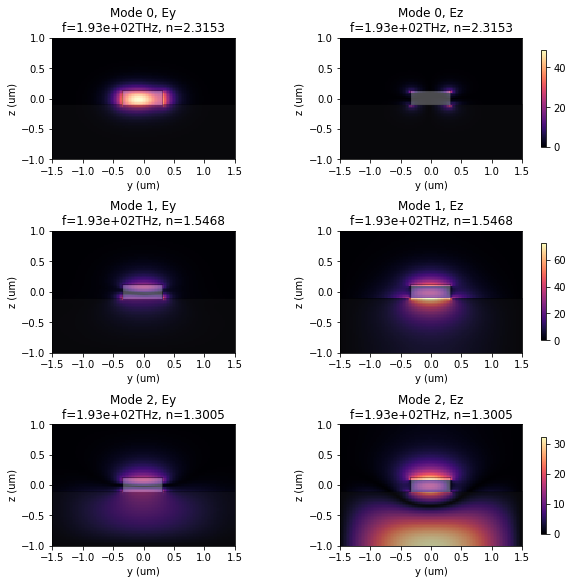

In [10]:
sim.compute_modes(msource, Nmodes=3)
sim.viz_modes(msource, cbar=True)
plt.show()

In [11]:
sim.set_mode(msource, mode_ind=0)

task_id = web.run(sim, task_name="angled_mode")

Mode set, recommend verifying using viz_modes.
Uploading the json file...
Project 'angled_mode-16b87a8932480c10' status: success...                                

Loading monitor data into simulation.
Applying source normalization to all frequency monitors using source index 0.


Transmission flux:  0.9932886640464016
Flux in mode 0:     1.0010506744631118


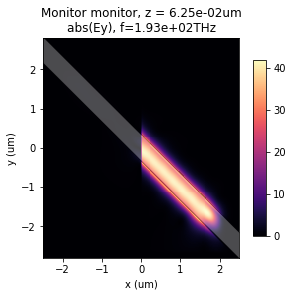

In [12]:
mdata = sim.data(mnt_f)
print("Transmission flux: ", np.abs(mdata["flux"][0, 0]))
print("Flux in mode 0:    ", np.abs(mdata["mode_amps"][0][0, 0])**2)
im = sim.viz_field_2D(freq_mnt, cbar=True, val='abs', comp='y');

### Modes with both a bend and an angle

We can also compose the two functionalities to inject and record modes in a bent waveguide in which the bend curvature is not in the same plane as the mode plane. This is illustrated below, using the same ring simulation but with a modification of the position of the `ModeSource` and `ModeMonitor`.

Initializing simulation...
Mesh step (micron): [2.50e-02, 2.50e-02, 2.50e-02].
Simulation domain in number of grid points: [220, 304, 144].
Total number of computational grid points: 9.63e+06.
Total number of time steps: 23864.
Estimated data size (GB) of monitor monitor: 0.0032.
Estimated data size (GB) of monitor monitor_1: 0.0000.


<AxesSubplot:title={'center':'yz-plane at x=0.00e+00um'}, xlabel='y (um)', ylabel='z (um)'>

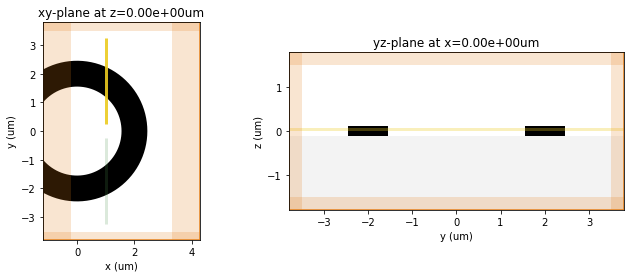

In [13]:
# offset the source and monitor position by 'angle' along the ring
angle = np.pi/6

# Simulation size for the ring simulation
sim_length = radius + 1.5
sim_size = [sim_length, 2*(radius + 1.5), 3]

# Note: angle_phi = 0
src_angled = td.ModeSource(
    center=[radius * np.sin(angle), -radius * np.cos(angle), 0],
    size=[0, 3, 2],
    source_time = td.GaussianPulse(
        frequency=freq0,
        fwidth=fwidth),
    direction='forward',
    angle_theta=angle,
    angle_phi=0)

# Note: angle_phi = np.pi
mnt_angled = td.ModeMonitor(
    center=[radius * np.sin(angle), radius * np.cos(angle), 0],
    size=[0, 3, 2],
    freqs=[freq0],
    angle_theta=angle,
    angle_phi=np.pi,
    store=['mode_amps', 'flux'])

# Simulation
sim = td.Simulation(
    center=[sim_length/2 - 0.2, 0, 0],
    size=sim_size,
    resolution=resolution, 
    structures=[substrate, cyl2, cyl1], 
    sources=[src_angled], 
    monitors=[freq_mnt, mnt_angled],
    run_time=run_time,
    pml_layers=['absorber', 'standard', 'standard'],
    subpixel=True)
            
fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1.5])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.viz_eps_2D(normal='z', ax=ax1, monitor_alpha=0.9, source_alpha=0.2);
sim.viz_eps_2D(normal='x', ax=ax2);

In [14]:
sim.set_mode(src_angled, mode_ind=0, bend_radius=-radius, bend_axis='z')
sim.set_monitor_modes(mnt_angled, bend_radius=radius, bend_axis='z', Nmodes=3)
task_id = web.run(sim, task_name="ring_angled_mode")

Mode set, recommend verifying using viz_modes.
Uploading the json file...
Project 'ring_angled_mode-16b87a9a91ed1000' status: success...                                

Loading monitor data into simulation.
Applying source normalization to all frequency monitors using source index 0.


Transmission flux:  1.0014488406310922
Flux in mode 0:     0.99375013939959


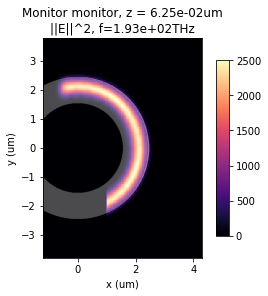

In [15]:
mdata = sim.data(mnt_angled)
print("Transmission flux: ", np.abs(mdata["flux"][0, 0]))
print("Flux in mode 0:    ", np.abs(mdata["mode_amps"][1][0, 0])**2) # note: 'backward' mode amplitude

im = sim.viz_field_2D(freq_mnt, cbar=True, val='int');